In [84]:
import pandas as pd
import geopandas as gpd

In [85]:
df = pd.read_excel("NFHS_5_India_Districts_Factsheet_Data.xls")

In [86]:
df = df[["District Names","State/UT","Children under 5 years who are stunted (height-for-age)18 (%)"]]

In [87]:
df = df[df["State/UT"]=="Maharastra"]

In [88]:
df = df.drop(columns=["State/UT"])

In [89]:
df = df.rename(columns={
    "Children under 5 years who are stunted (height-for-age)18 (%)": "stunted_children"
})


In [90]:
df

,District Names,stunted_children
349,Nandurbar,45.82
350,Dhule,37.60
351,Jalgaon,36.34
352,Buldana,44.95
353,Akola,31.79
354,Washim,35.32
355,Amravati,29.04
356,Wardha,27.65
357,Nagpur,27.60
358,Bhandara,31.25


In [91]:
df["District Names"].unique()

array(['Nandurbar ', 'Dhule ', 'Jalgaon ', 'Buldana ', 'Akola ',
       'Washim ', 'Amravati ', 'Wardha ', 'Nagpur ', 'Bhandara ',
       'Gondiya ', 'Gadchiroli ', 'Chandrapur ', 'Yavatmal ', 'Nanded ',
       'Hingoli ', 'Parbhani ', 'Jalna ', 'Aurangabad ', 'Nashik ',
       'Mumbai Suburban ', 'Mumbai ', 'Raigarh ', 'Pune ', 'Ahmadnagar ',
       'Bid ', 'Latur ', 'Osmanabad ', 'Solapur ', 'Satara ',
       'Ratnagiri ', 'Sindhudurg ', 'Kolhapur ', 'Sangli ', 'Palghar ',
       'Thane '], dtype=object)

In [92]:
gdf = gpd.read_file("MAHARASHTRA_DISTRICTS.geojson")

In [93]:
gdf.dtname.unique()

array(['Gondiya', 'Bhandara', 'Jalgaon', 'Wardha', 'Buldana', 'Akola',
       'Nashik', 'Gadchiroli', 'Washim', 'Chandrapur', 'Yavatmal',
       'Jalna', 'Ahmadnagar', 'Hingoli', 'Nanded', 'Parbhani', 'Pune',
       'Bid', 'Mumbai', 'Latur', 'Osmanabad', 'Solapur', 'Satara',
       'Ratnagiri', 'Sangli', 'Kolhapur', 'Sindhudurg', 'Thane',
       'Palghar', 'Nandurbar', 'Amravati', 'Dhule', 'Nagpur',
       'Aurangabad', 'Raigarh', 'Mumbai Suburban'], dtype=object)

In [94]:
# Strip and sort
df['District Names'] = df['District Names'].str.strip()
gdf['dtname'] = gdf['dtname'].str.strip()

# Unique values
df_districts = set(df['District Names'].unique())
gdf_districts = set(gdf['dtname'].unique())


In [95]:
# Districts in df but not in gdf
extra_in_df = df_districts - gdf_districts
print("Districts in df but not in gdf:", extra_in_df)

# Districts in gdf but not in df
extra_in_gdf = gdf_districts - df_districts
print("Districts in gdf but not in df:", extra_in_gdf)


Districts in df but not in gdf: set()
Districts in gdf but not in df: set()


In [96]:
# Perform the merge
merged_df = gdf.merge(df, left_on='dtname', right_on='District Names', how='left')


In [97]:
merged_df.columns

Index(['dtname', 'stname', 'stcode11', 'dtcode11', 'year_stat', 'Shape_Length',
       'Shape_Area', 'OBJECTID', 'test', 'Dist_LGD', 'State_LGD', 'geometry',
       'District Names', 'stunted_children'],
      dtype='object')

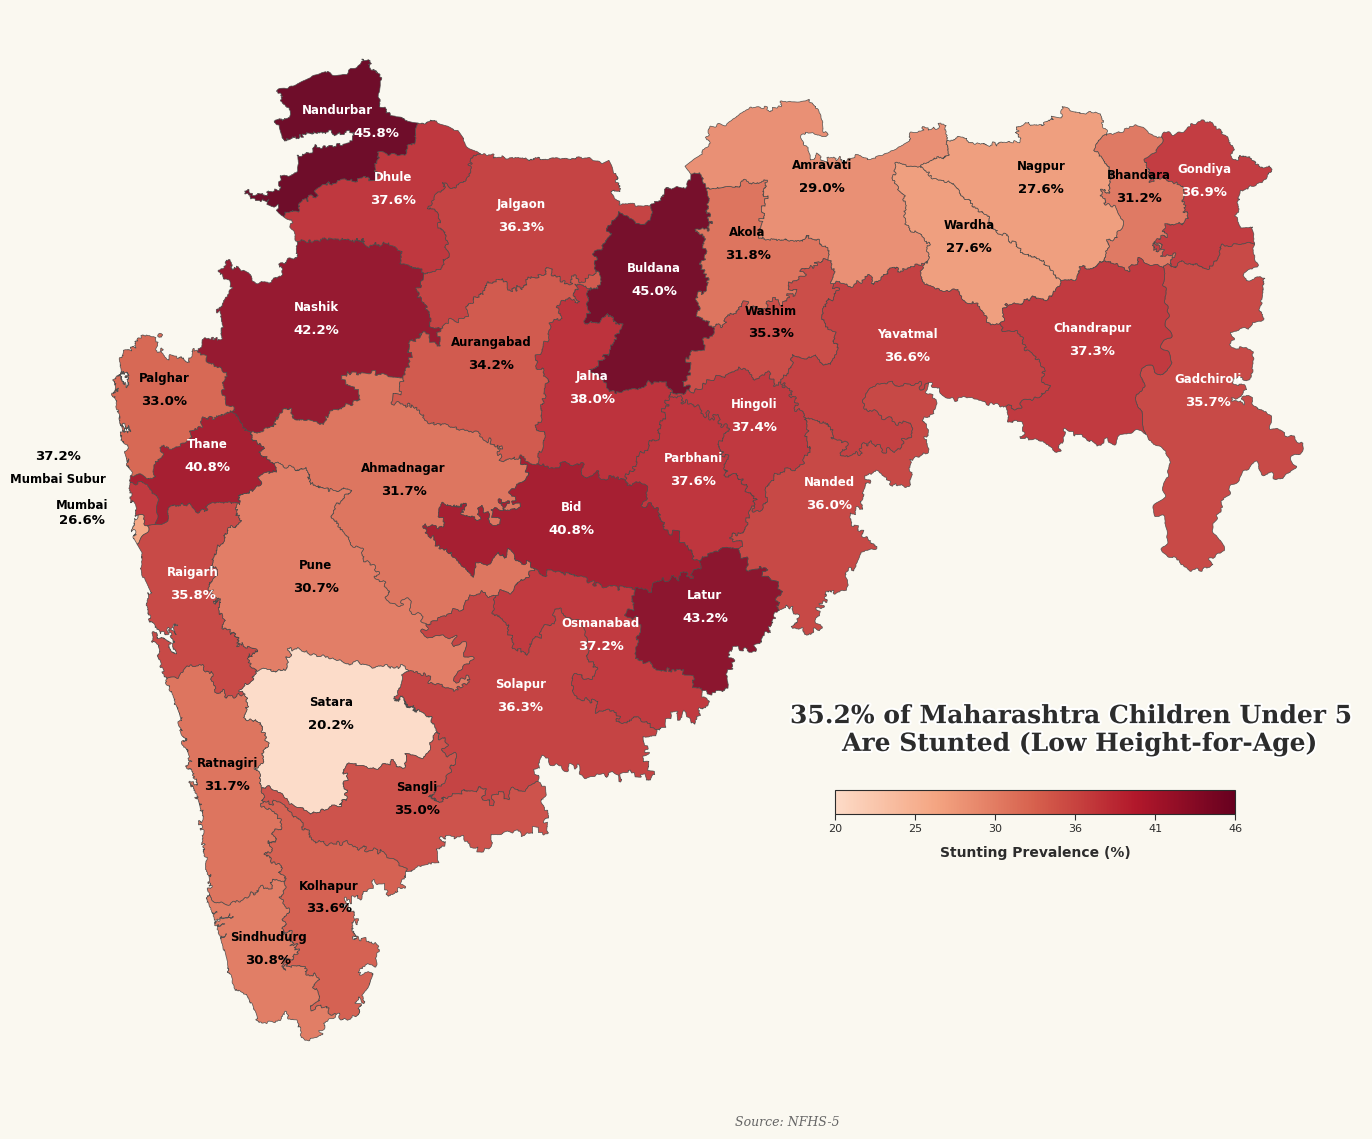

In [98]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.patheffects as path_effects
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')

def create_district_stunting_map(final_df):
    fig = plt.figure(figsize=(16, 12))
    fig.patch.set_facecolor('#faf8f0')

    ax_map = plt.axes([0.05, 0.05, 0.9, 0.9])
    ax_map.set_facecolor('#faf8f0')

    # Custom colormap (red shades)
    colors_list = ['#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
    custom_cmap = LinearSegmentedColormap.from_list('stunting_cmap', colors_list, N=256)

    # Normalize for color scaling
    norm = Normalize(vmin=final_df['stunted_children'].min(), vmax=final_df['stunted_children'].max())

    # Fill colors based on stunting values
    colors = final_df['stunted_children'].apply(
        lambda x: custom_cmap(norm(x)) if pd.notnull(x) else (0.95, 0.95, 0.95, 1.0)
    )

    # Plot districts
    final_df.plot(
        ax=ax_map,
        color=colors.tolist(),
        edgecolor='#4a4a4a',
        linewidth=0.5,
        alpha=0.95
    )

    # Function to determine text color
    def get_text_color(value):
        if pd.isnull(value):
            return 'black'
        normalized_val = norm(value)
        return 'white' if normalized_val > 0.6 else 'black'

    # Add district name and stunting percentage
    for _, row in final_df.iterrows():
        point = row['geometry'].centroid

        # === Custom positioning overrides ===
        if row['dtname'] == 'Mumbai':
            point_x = point.x - 0.4
            point_y = point.y
            text_color = 'black'
            perc_offset_y = 0.05
            perc_offset_x = 0
        elif row['dtname'] == 'Mumbai Suburban':
            point_x = point.x - 0.6
            point_y = point.y
            text_color = 'black'
            perc_offset_y = 0.3
            perc_offset_x = 0
        elif row['dtname'] == 'Nandurbar':
            point_x = point.x
            point_y = point.y
            text_color = get_text_color(row['stunted_children'])
            perc_offset_x = 0.27
            perc_offset_y = 0.0
        else:
            point_x = point.x
            point_y = point.y
            text_color = get_text_color(row['stunted_children'])
            perc_offset_x = 0.0
            perc_offset_y = 0.0

        # District name
        ax_map.text(
            point_x, point_y + 0.15, row['dtname'][:12],
            ha='center', va='center', fontsize=8.5, fontweight='bold',
            color=text_color, fontfamily='sans-serif'
        )

        # Stunting percentage
        if pd.notnull(row['stunted_children']):
            ax_map.text(
                point_x + perc_offset_x, point_y + perc_offset_y,
                f"{row['stunted_children']:.1f}%",
                ha='center', va='center', fontsize=9.5, fontweight='bold',
                color=text_color, fontfamily='sans-serif'
            )

    # Title
    ax_map.set_title(
        '',
        fontsize=18, fontweight='bold', fontfamily='serif', pad=20, color='#2c2c2c',
        path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
    )

    ax_map.set_axis_off()

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm._A = []

    cbar_ax = fig.add_axes([0.58, 0.28, 0.25, 0.02])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=8, colors='#2c2c2c', length=4)
    cbar.set_label('Stunting Prevalence (%)', fontsize=10, fontweight='bold',
                   color='#2c2c2c', labelpad=8)
    cbar.outline.set_edgecolor('#2c2c2c')

    tick_positions = np.linspace(final_df['stunted_children'].min(), final_df['stunted_children'].max(), 6)
    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels([f'{x:.0f}' for x in tick_positions])

    # Annotation above colorbar (optional stat)
    avg_stunting = final_df['stunted_children'].mean()
    fig.text(
        0.73, 0.35,
        '35.2% of Maharashtra Children Under 5 \n Are Stunted (Low Height-for-Age)',
        ha='center', va='center',
        fontsize=18, fontweight='bold', fontfamily='serif', color='#2c2c2c',
        path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
    )

    # Footer
    plt.figtext(
        0.55, 0.02,
        'Source: NFHS-5',
        ha='center', fontsize=9, color='#666666',
        style='italic', fontfamily='serif'
    )

    plt.tight_layout()
    return fig


# === Execution ===
merged_df['stunted_children'] = pd.to_numeric(merged_df['stunted_children'], errors='coerce')

fig = create_district_stunting_map(merged_df)

# Save to file
fig.savefig('district_stunting_map.png', dpi=300, bbox_inches='tight',
            facecolor=fig.get_facecolor(), edgecolor='none')

plt.show()
